# Implicit/Iterative/Early-Stopping Regularization

<font color='green'> In this practical session, we introduce the concept of implicit (also called iterative or early-stopping) regularization. Our main objectives are the following:
</font>
- <font color='green'>understanding connections between ridge regression regularization and iterative regularization via gradient descent;</font>
- <font color='green'>introducing an algorithm with sparsity-inducing implicit regularization effect;</font>
- <font color='green'>understanding how the choice of an optimization algorithm can impact the statistical properties of the traced optimization path.</font>

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.experimental.numpy as tnp 
tnp.experimental_enable_numpy_behavior()

## Reusing Code From the "Optimization" Practical Session

We begin this session by importing some of the code already used in the "optimization" practical session. First, we will reuse our code for running gradient descent simulations by importing the `Optimizer` and `GradientDescent` classes.

In [ ]:
class Optimizer(object):
  """ A base class for optimizers. """

  def __init__(self, eta):
    """ :eta_t: A function taking as argument the current iteration t and
          returning the step size eta_t to be used in the current iteration. """
    super().__init__()
    self.eta = eta
    self.t = 0 # Set iterations counter.

  def apply_gradient(self, x_t, g_t):
    """ Given the current iterate x_t and gradient g_t, updates the value
      of x_t to x_(t+1) by performing one iterative update.
        :x_t: A tf.Variable which value is to be updated.
        :g_t: The gradient value, to be used for performing the update.
    """
    raise NotImplementedError("To be implemented by subclasses.")

  def step(self, f, x_t):
    """ Updates the variable x_t by performing one optimization iteration.
        :f: A function which is being minimized.
        :x_t: A tf.Variable with respect to which the function is being
          minimized and which value is to be updated
.
    """
    with tf.GradientTape() as tape:
      fx = f(x_t)
    g_t = tape.gradient(fx, x_t)
    self.apply_gradient(x_t, g_t)
    # Update the iterations counter.
    self.t += 1

  def optimize(self, f, x_t, n_iterations):
    """ Applies the function step n_iterations number of times, starting from
      the iterate x_t. Note: the number of iterations member self.t is not
      restarted to 0, which may affects the computed step sizes. 
        :f: Function to optimize.
        :x_t: Current iterate x_t.
        :returns: A list of length n_iterations+1, containing the iterates
          [x_t, x_{t+1}, ..., x_{t+n_iterations}].
    """
    x = tf.Variable(x_t)
    iterates = []
    iterates.append(x.numpy().reshape(-1,1))
    for _ in range(n_iterations):
      self.step(f, x)
      iterates.append(x.numpy().reshape(-1,1))
    return iterates

In [ ]:
class GradientDescent(Optimizer):
  """ An implementation of gradient descent uptades. """

  def apply_gradient(self, x_t, g_t):
    eta_t = self.eta(self.t)
    x_t.assign_add(-eta_t * g_t)

It will be helpful to visualize the solution paths generated by different procedures. We will reuse the class `Convergence2DPlotting` from the "optimization" practical session notebook.

In [ ]:
class Convergence2DPlotting(object):
  """ Plotting utils for visualizing optimization paths on 2D functions. """

  def __init__(self):
    self.fig, self.ax = plt.subplots()
    self.fig.set_size_inches(8.0, 8.0)
    self.ax.set_aspect('equal')

  def plot_iterates(self, iterates, color='C0'):
    iterates = np.array(iterates).squeeze()
    x, y = iterates[:,0], iterates[:, 1]
    self.ax.scatter(x,y,s=0)
    for i in range(len(x)-1):
      self.ax.annotate('', xy=(x[i+1], y[i+1]), xytext=(x[i], y[i]),
                       arrowprops={'arrowstyle': '->',
                                  'color':  color, 'lw': 2})

  def plot_contours(self, f):
    x_min, x_max = self.ax.get_xlim()
    y_min, y_max = self.ax.get_ylim()

    # Generate the contours of f on the above computed range.
    n_points = 50
    x = np.linspace(start=x_min, stop=x_max, num=n_points)
    y = np.linspace(start=y_min, stop=y_max, num=n_points)
    x, y = np.meshgrid(x, y)
    z = np.zeros_like(x)
    for x_idx in range(n_points):
      for y_idx in range(n_points):
        input = np.array([x[x_idx, y_idx], y[x_idx, y_idx]]).reshape(2,1)
        z[x_idx, y_idx] = f(input)
    self.ax.contour(x,y,z, colors='k')

## Ridge Regression vs Unregularized Gradient Descent

In this section, we attempt to understand the similarities between the ridge regression *regularization paths* and gradient descent *optimization paths* obtained by applying gradient descent updates to the *unregularized* empirical risk. For simplicity, we will consider a simple data-generating mechanism given by
\begin{align*}
  X &\sim N(0, I_{d}), \\
  Y \mid X = x &\sim N(\langle w^{\star}, x\rangle, \sigma^{2}),
\end{align*}
where $w^{\star} \in \mathbb{R}^{d}$ denotes some ground-truth parameter.
We implement code for sampling data from such distributions in the following cell.


In [ ]:
class GaussianData(object):
  """ A class for sampling Gaussian data with i.i.d. N(0, I_d) covariates. """
  
  def __init__(self, n, d, w_star, noise_std):
    """ :n: Number of data points.
        :d: Dimension of the covariates.
        :w_star: A d-dimensional vector used to generate noisy observations
          y_i = <w_star, x_i> + N(0, noise_std**2).
        :noise_std: Standard deviation of the zero-mean Gaussian label noise.
    """
    self.n = n
    self.d = d
    self.w_star = w_star.reshape(self.d, 1)
    self.noise_std = noise_std
    self.resample_data(seed=0)

  def resample_data(self, seed):
    """ Resamples dataset X, y using the given seed and stores it as class
      members. """
    np.random.seed(seed)
    self.X = np.random.normal(loc=0.0, scale=1.0, size=(self.n, self.d))
    self.xi = np.random.normal(loc=0.0, scale=1.0, size=(self.n, 1))
    self.y = self.X @ self.w_star + self.xi

  def compute_empirical_risk(self, w):
    """ For a d-dimensional vector w, outputs R(w) = 1/n ||Xw - y||_{2}^{2}. """
    return tnp.average((self.X @ w - self.y)**2)

  def compute_population_risk(self, w):
    """ For a d-dimensional vector w, outputs
      r(w) = ||w-w*||_{2}^{2} + noise_std**2. """
    return tnp.sum((w - self.w_star)**2) + self.noise_std**2

For the next exercise, fix the following setup. You are encouraged, however, to also experiment with other parameter choices.

In [ ]:
isotropic_gaussian_2d_data = GaussianData(
    n=15,
    d=2, # d=2 for visualizing the paths.
    w_star=np.array([1.0, 0.0]), # Make w* "sparse".
    noise_std=1.0)

### Exercise 1

This exercise introduces some connections between ridge regression and gradient descent applied to unregularized empirical risk. In your simulations, use the `isotropic_gaussian_2d_data` object, which contains  two-dimensional Gaussian dataset $X, y$, where $X \in \mathbb{R}^{n \times 2}$ and $y \in \mathbb{R}^{n}$.

- For a grid of $m$ regularization parameters $\lambda_{1}, \dots, \lambda_{m}$ of your choice, compute ridge regression estimates $w_{\lambda}^{\text{ridge}} = \mathrm{argmin}_{w \in \mathbb{R}^{d}} \frac{1}{n}\|Xw - y\|_{2}^{2} + \frac{\lambda}{n}\|w\|_{2}^{2}$.

- Let $w_{0}^{\text{gd}} = 0$. For some numer of iterations $T$ of your choice, compute iterates of gradient descent $w^{\text{gd}}_{t+1} = w^{\text{gd}}_{t} - \eta \nabla R(w_{t}^{\mathrm{gd}})$, where $R(w) = \frac{1}{n}\|Xw - y\|_{2}^{2}$ is the empirical risk and $\eta > 0$  is some constant step size (the exact value does not matter, as long as it is small enough).

- Plot the population risks attained by ridge regression *regularization path* $(w^{\text{ridge}}_{\lambda_{i}})_{i=1}^{m}$ and gradient descent *optimization path* $(w^{\text{gd}}_{t})_{t=0}^{T}$. Comment on your findings.

- Using the class `Convergence2DPlotting` visualize the computed ridge regression regularization path and gradient descent optimization path.

- Comment on different computational considerations concerning the computation of regularization and optimization paths.

#### Solution

For a given $\lambda > 0$, ridge regression estimate $w_{\lambda}$ can be computed by $(X^{\mathsf{T}}X + \lambda I)^{-1} X^{\mathsf{T}}y$. We implement computation of ridge regression regularization paths below.

In [ ]:
def compute_ridge_regression_regularization_path(data, lambdas):
  """ :data: An object of type GaussianData.
      :lambdas: A sorted list of regularization parameters lambda.
      :returns: A list of fitted parameters w_{\lambda}, one for
        each provided lambda.
  """
  # Compute and store the values of X^{t}X and X^{t}y and Id.
  XtX = np.transpose(data.X) @ data.X
  Xty = np.transpose(data.X) @ data.y
  Id = np.identity(data.d)
  
  regularization_path = []
  for l in lambdas:
    w_lambda = np.linalg.inv(XtX + l*Id) @ Xty
    regularization_path.append(w_lambda)
  return regularization_path

In [ ]:
# Create a grid of regularization parameters equally spaced on a log scale.
lambdas = np.exp(np.linspace(start=np.log(10**(-3)), stop=np.log(1e3),
                             num=2000))
ridge_regularization_path = compute_ridge_regression_regularization_path(
    isotropic_gaussian_2d_data, lambdas)

Computation of gradient descent optimization path can be readily obtained via `GradientDescent` optimizer class.

In [ ]:
T = 2000
eta = lambda t: 0.001
w_0 = np.zeros(isotropic_gaussian_2d_data.d).reshape(-1, 1)
gradient_descent = GradientDescent(eta)
gd_optimization_path = gradient_descent.optimize(
  isotropic_gaussian_2d_data.compute_empirical_risk, w_0, T)

We can now compare the population (or out-of-sample) risks attained by ridge regression and gradient descent.

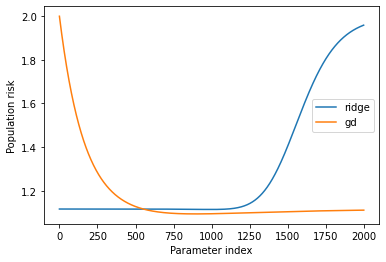

In [ ]:
ridge_risks = [isotropic_gaussian_2d_data.compute_population_risk(w) \
               for w in ridge_regularization_path]
gd_risks = [isotropic_gaussian_2d_data.compute_population_risk(w) \
            for w in gd_optimization_path]
plt.plot(ridge_risks)
plt.plot(gd_risks)
plt.xlabel('Parameter index')
plt.ylabel('Population risk')
plt.legend(['ridge', 'gd'])

We observe that the minimum population risk achieved by both algorithms is approximately the same. Notice that large values of $\lambda$ for ridge regression correspond to small values of $t$ for gradient descent (i.e., using a lot of regularization). On the other hand, small values of $\lambda$ correspond to large values of $t$ (using little regularization).

Let us now plot the obtained regularization and optimization paths against the contours of the population risk.

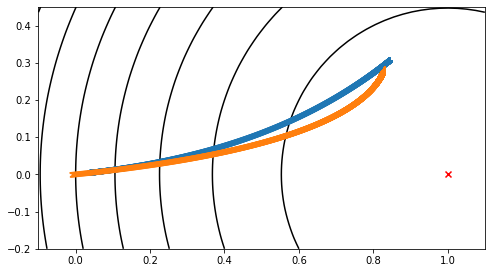

In [ ]:
path_plots = Convergence2DPlotting()
path_plots.plot_iterates(ridge_regularization_path, color='C0')    
path_plots.plot_iterates(gd_optimization_path, color='C1')
path_plots.ax.set_ylim(-0.2, 0.45)
path_plots.ax.set_xlim(-0.1, 1.1)
path_plots.plot_contours(isotropic_gaussian_2d_data.compute_population_risk)
path_plots.ax.scatter(isotropic_gaussian_2d_data.w_star[0],
                      isotropic_gaussian_2d_data.w_star[1],
                      marker='x',
                      color='red')

<font color='green'>**We observe that gradient descent optimization path nearly matches that of ridge regression regularization path.**</font> We will make this observation more precise in the next exercise.

Finally, regarding the computational considerations, notice that we generated new points along ridge regression optimization problem by solving a new optimization problem for each value of $\lambda$. While there are better ways to compute regularization paths (e.g., based on *warm restarts*), computational analysis and implementation might become more tricky in such cases. On the other hand, obtaining new iterates along the gradient optimization path only cost one gradient descent update, resulting in arguably simpler and more efficient procedure.

<font color='green'>**We observe that the gradient descent optimization path nearly matches that of the ridge regression regularization path.**</font> We will make this observation more precise in the next exercise.

Finally, regarding the computational considerations, notice that <font color='green'>**we generated new points along the ridge regularization path by solving a new optimization problem for each value of $\lambda$.**</font> While there are better ways to compute regularization paths (e.g., based on *warm restarts*), computational analysis and implementation might become more tricky in such cases. On the other hand, <font color='green'>**obtaining new iterates along the gradient optimization path only cost one gradient descent update**</font>, resulting in an arguably more straightforward and more efficient procedure.

### Exercise 2

In exercse 1, we have observed that the gradient descent optimization path nearly matches the ridge regression regularization path. In this exercise we investigate why this happens. Recall that ridge regression estimates $w_{\lambda}$ can be computed via the following expression:
$$
  w_{\lambda} = T^{\text{ridge}}_{\lambda}(X^{\mathsf{T}}X)X^{\mathsf{T}}y ,\text{ where }
  T^{\text{ridge}}_{\lambda}(X^{\mathsf{T}}X) = (X^{\mathsf{T}}X + \lambda I_{d})^{-1}.
$$
The mapping $T_{\lambda}^{\text{ridge}}$ can be seen as an operator acting on the eigenvalues of the sample covariance matrix $X^{\mathsf{T}}X$. In particular, $T_{\lambda}^{\text{ridge}}$ aims to invert the eigenvalues of $X^{\mathsf{T}}X$, with the inverse getting closer to the true inverse as $\lambda \to 0$.

- Find an expression for some operator $T^{\text{gd}}_{\eta, t}$ acting on the eigenvalues of $X^{\mathsf{T}}X$, such that the $t$-th iterate of gradient descent, obtained with a constant step-size $\eta$ and $w_0 = 0$ satisfies
$$
  w_{t} = T^{\text{gd}}_{\eta, t}(X^{\mathsf{T}}X)X^{\mathsf{T}}y.
$$
- Using the above-computed expression, suggest (informally) some mapping $f$ between $\lambda$ and $(\eta, t)$, such that $w^{\text{ridge}}_{\lambda} \approx w^{\text{gd}}_{t}$.
- Using the above-suggested mapping $f$ which approximately corresponds to $\lambda = f(\eta, t)$, plot gradient descent and ridge regression population risks computed in Exercise 1. For the x-axis, use the number of gradient descent iterations. The ridge regression lambdas should be renormalized using the mapping $f$. **You should find a mapping $f$ such that the two curves approximately overlap.**

#### Solution

For gradient descent, it can be shown by induction that
$$
  w_{t}^{\text{gd}} = \underbrace{\frac{2\eta}{n}\left(I + \left(I - \frac{2\eta}{n}X^{\mathsf{T}}X\right) + \dots + \left(I - \frac{2\eta}{n}X^{\mathsf{T}}X\right)^{t-1}\right)}_{= T_{\eta,t}^{\text{gd}}(X^{\mathsf{T}}X) }X^{\mathsf{T}}y.
$$
Suppose that the eigenvalues of $X^{\mathsf{T}}X$ are given by $\mu_{1}, \dots, \mu_{d}$. Then, the operator $T_{\eta,t}^{\text{gd}}$ acts on the $i$-th eigenvalue $\mu_{i}$ via the formula:
$$
  \mu_{i} \mapsto \frac{2\eta}{n}\sum_{s=0}^{t-1}\left(1 - \frac{2\eta}{n}\mu_{i}\right)^{s}
  =
  \frac{1 - \left(1 - \frac{2\eta}{n}\mu_{i}\right)^{t}}{\mu_{i}}.
$$
<font color='green'>**In essence, the gradient descent iterates are inverting the eigenvalues of the sample covariance matrix using a slightly different formula than ridge regression.**</font>
Recall that the corresponding ridge operator $T_{\lambda}^{\text{ridge}}$ acts on the $i$-th eigenvalue $\mu_{i}$ via the mapping
$$
  \mu_{i} \mapsto \frac{1}{\mu_{i} + \lambda}.
$$
Equating the right-hand sides of the two expressions above, we for given values of $\lambda$ and $\eta$, we want to find $t$ such that
$$
  \frac{1 - \left(1 - \frac{2\eta}{n}\mu_{i}\right)^{t}}{\mu_{i}}
  \approx \frac{1}{\mu_{i} + \lambda}.
$$
In the isotropic setting considered in our simulations, we have $\mu_{1} \approx \mu_{2} \approx n$. Solving the above equation for $t$ yields the expression
$$
  t \approx \frac{\log\frac{\lambda}{n + \lambda}}{\log(1-2\eta)}.
$$
We apply the above formula in the below code cell. Observe that the generated risk curves using this mapping are aligned as required.

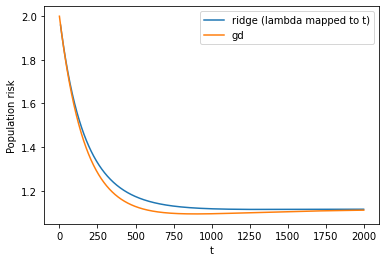

In [ ]:
# Note that small lambda corresponds to large T (i.e., fitting to convergence).
eta = gradient_descent.eta(0)
X = isotropic_gaussian_2d_data.X
n = X.shape[0]
remapped_lambdas = np.log(lambdas/(n +lambdas)) / np.log(1.0 - 2.0*eta)
# We want to keep the largest remmaped_lambdas element up to T, so we will
# remove some part of this above lambdas.
truncate_idx = np.argmin(remapped_lambdas > T)
plt.plot(remapped_lambdas[truncate_idx:], ridge_risks[truncate_idx:])
plt.plot(np.arange(T+1), gd_risks)
plt.xlabel('t')
plt.ylabel('Population risk')
plt.legend(['ridge (lambda mapped to t)', 'gd'])

## Sparsity-Inducing Implicit Regularization

In the previous section we have seen how gradient descent applied to the unregularized empirical risk generate iterates that approximately correspond to the ridge regression regularization path. Ridge regularization is, of course, just one of the many ways to induce a regularizing effect. For instance, for learning problems with some underlying sparsity structure, lasso regularization might be preferred, giving the regularization path $(w_{\lambda}^{\text{lasso}})_{\lambda \geq 0}$ whose iterates are defined by
$$
  w_{\lambda} \in \mathrm{argmin}_{w \in \mathbb{R}^{d}} \frac{1}{n} \|Xw - y\|_{2}^{2} + \frac{\lambda}{n}\|w\|_{1}.
$$
Indeed, the toy setup explored in our previous simulations exhibits some underlying sparsity structure, as the parameter that generates the data $w^{\star} = (1, 0)^{\mathsf{T}}$ can be considered as a sparse vector.
 We can indeed show that the lasso regularization path contains marginally better solutions for our two-dimensional toy problem than the ridge regularization path (for larger and more sparse problems lasso penalties would significantly outperform ridge penalties).

In [ ]:
from sklearn import linear_model

def compute_lasso_regression_regularization_path(data, lambdas):
  regularization_path = []
  for l in lambdas:
    lasso = linear_model.Lasso(alpha=l/(2.0*n), fit_intercept=False)
    lasso.fit(data.X, data.y)
    w_lambda = lasso.coef_.reshape(-1, 1)
    regularization_path.append(w_lambda)
  return regularization_path

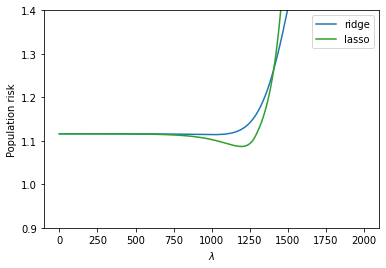

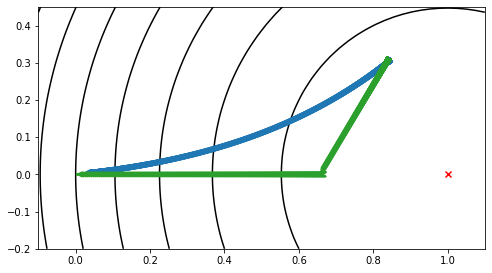

In [ ]:
lasso_regularization_path = compute_lasso_regression_regularization_path(
    isotropic_gaussian_2d_data, lambdas)
lasso_risks = [isotropic_gaussian_2d_data.compute_population_risk(w) \
               for w in lasso_regularization_path]
plt.plot(ridge_risks, color='C0')
plt.plot(lasso_risks, color='C2')
plt.xlabel(r'$\lambda$')
plt.ylabel('Population risk')
plt.legend(['ridge', 'lasso'])
plt.ylim(0.9,1.4)
plt.show()
path_plots = Convergence2DPlotting()
path_plots.plot_iterates(ridge_regularization_path, color='C0')    
path_plots.plot_iterates(lasso_regularization_path, color='C2')
path_plots.ax.set_ylim(-0.2, 0.45)
path_plots.ax.set_xlim(-0.1, 1.1)
path_plots.plot_contours(isotropic_gaussian_2d_data.compute_population_risk)
path_plots.ax.scatter(isotropic_gaussian_2d_data.w_star[0],
                      isotropic_gaussian_2d_data.w_star[1],
                      marker='x',
                      color='red')

A natural question occurs: <font color='green'>**how can one introduce a non-Euclidean regularization effect implicitly?**</font> In the following exercise, we present one such way, which induces a sparsity-promoting regularization effect by running gradient descent on a reparametrized coordinate system.

### Exercise 3

For a vector $u \in \mathbb{R}^{d}$ let $u^{2}$ denote a component-wise square operation. Consider the reparametrization $w = u^{2}$ (viable for any $w \in \mathbb{R}^{d}$ with non-negative components (to treat the general case, we could instead consider $w = u^{2} - v^{2}$; for simplicity, we will consider the reparametrization $w = u^{2}$ only).

In the new coordinate system $w = u^{2}$, the empirical risk function is defined as
$$
  \widetilde{R}(u) = \frac{1}{n} \|Xu^{2} - y\|_{2}^{2}.
$$
Consider setting $u_{0} = (0.01, 0.01)^{\mathsf{T}}$ and running gradient descent on $\widetilde{R}$ for the problem instance stored in the python variable `isotropic_gaussian_2d_data`:
- plot the population risks traced by the gradient descent iterates $(u_{t})_{t=0}^{T}$;
- plot the two-dimensional optimization path;
- compare the simulation output with the ridge and lasso regularization paths.

#### Solution

The reparametrized gradient descent can be implemented in just a few lines by redefining the function we want to optimize in the new coordinate system.

In [ ]:
class ReparametrizedGradientDescent(GradientDescent):

  def optimize(self, f, w_0, n_iterations):
    """ The initialization point w_0 needs to have stricly positive coordinates.
    This function optimizes f using reparametrization w = u^2, running gradient
    descent updates on the parameter u. """
    def g(u):
      return f(u**2)
    u_0 = tnp.sqrt(w_0)
    u_iterates = super().optimize(g, tnp.sqrt(w_0), n_iterations)
    w_iterates = [u**2 for u in u_iterates]
    return w_iterates

We can now execute the algorithm.

In [ ]:
w_0 = np.array([1e-4, 1e-4]).reshape(-1, 1)
reparametrized_gd = ReparametrizedGradientDescent(eta = lambda t : 0.005)
reparametrized_iterates = reparametrized_gd.optimize(
    isotropic_gaussian_2d_data.compute_empirical_risk, w_0, 2000)
reparametrized_gd_risks = [isotropic_gaussian_2d_data.compute_population_risk(w) \
               for w in reparametrized_iterates]

Finally, we can visually observe that the reparametrized gradient descent is indeed biased towards first exploring sparse iterates.

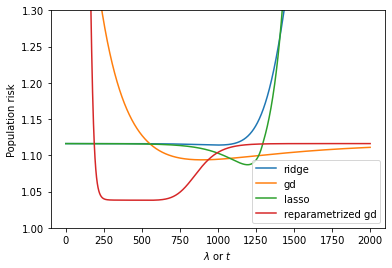

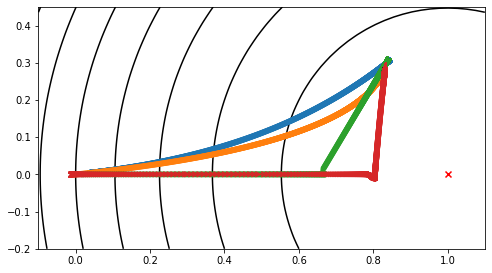

In [ ]:
plt.plot(ridge_risks, color='C0')
plt.plot(gd_risks, color='C1')
plt.plot(lasso_risks, color='C2')
plt.plot(reparametrized_gd_risks, color='C3')
plt.xlabel(r'$\lambda$ or $t$')
plt.ylabel('Population risk')
plt.legend(['ridge', 'gd', 'lasso', 'reparametrized gd'])
plt.ylim(1.0,1.3)
plt.show()

path_plots = Convergence2DPlotting()
path_plots.plot_iterates(ridge_regularization_path, color='C0')    
path_plots.plot_iterates(gd_optimization_path, color='C1')
path_plots.plot_iterates(lasso_regularization_path, color='C2')
path_plots.plot_iterates(reparametrized_iterates, color='C3')
path_plots.ax.set_ylim(-0.2, 0.45)
path_plots.ax.set_xlim(-0.1, 1.1)
path_plots.plot_contours(isotropic_gaussian_2d_data.compute_population_risk)
path_plots.ax.scatter(isotropic_gaussian_2d_data.w_star[0],
                      isotropic_gaussian_2d_data.w_star[1],
                      marker='x',
                      color='red')

## Bibliographic Remarks

The use of early-stopping as a regularization mechanism dates back at least to Landweber iteration [*Landweber, 1951*] studied in the context of ill-posed inverse problems; for this point of view, see the textbook by *Engl, Hanke, and Neubauer [1996]*. As early as in the 90s, early stopping has also been one of the standard ways to regularize the training procedures used to fit neural network parameters [*Prechelt, 1998*]. In the statistics literature, the first
paper to connect early stopping to the notion of minimax optimality is due to *Bühlmann and Yu [2003]*. Implicit regularization effects in the Euclidean setting of gradient descent updates are by now well-understood; see, for example, the paper by *Yao, Rosasco, and Caponnetto [2007]*, *Raskutti, Wainwright, and Yu [2014]*, *Wei, Yang, and Wainwright [2019]*.
Much less is known about non-Euclidean setups. The quadratic reparametrization trick was noticed in [*Gunasekar, Woodworth, Bhojanapalli, Neyshabur, and Srebro, 2017*] in the context of matrix factorization. Linear regression setting with quadratic reparametrization was studied by *Vaškevičius, Kanade, and Rebeschini [2019]*, where minimax optimal bounds were obtained for early-stopped iterates under the signal-sparsity and the restricted isometry assumption on the design matrix. Later, it was shown in [*Vaškevičius, Kanade, and Rebeschini, 2020*] how to obtain estimation error upper bounds for early-stopped iterates of mirror descent algorithms via offset Rademacher complexities. For other works concerning early-stopping in non-Euclidean setups, see, for example, [*Osher, Ruan, Xiong, Yao, and Yin, 2016, Molinari,
Massias, Rosasco, and Villa, 2021, Wu and Rebeschini, 2021*].

**References**

P. Bühlmann and B. Yu. Boosting with the l2 loss: regression and classification. Journal of the American Statistical Association, 98(462):324–339, 2003.

H. W. Engl, M. Hanke, and A. Neubauer. Regularization of inverse problems, volume 375. Springer Science & Business Media, 1996.

S. Gunasekar, B. E. Woodworth, S. Bhojanapalli, B. Neyshabur, and N. Srebro. Implicit regularization in matrix factorization. In Advances in Neural Information Processing Systems, pages 6151–6159, 2017.

L. Landweber. An iteration formula for fredholm integral equations of the first kind. American journal of mathematics, 73(3):615–624, 1951.

C. Molinari, M. Massias, L. Rosasco, and S. Villa. Iterative regularization for convex regularizers. In International Conference on Artificial Intelligence and Statistics, pages 1684–1692. PMLR, 2021.

S. Osher, F. Ruan, J. Xiong, Y. Yao, and W. Yin. Sparse recovery via differential inclusions. Applied and Computational Harmonic Analysis, 41(2):436–469, 2016.

L. Prechelt. Early stopping-but when? In Neural Networks: Tricks of the trade, pages 55–69. Springer, 1998.

G. Raskutti, M. J. Wainwright, and B. Yu. Early stopping and non-parametric regression: an optimal data-dependent stopping rule. The Journal of Machine Learning Research, 15(1):335–366, 2014.

T. Vaškevičius, V. Kanade, and P. Rebeschini. The statistical complexity of early-stopped mirror descent. arXiv preprint arXiv:2002.00189, 2020.

T. Vaškevičius, V. Kanade, and P. Rebeschini. Implicit regularization for optimal sparse recovery. In Advances in Neural Information Processing Systems, pages 2968–2979, 2019.

Y. Wei, F. Yang, and M. J. Wainwright. Early stopping for kernel boosting algorithms: A general analysis with localized complexities. IEEE Transactions on Information Theory, 65(10):6685–6703, 2019.

F. Wu and P. Rebeschini. Nearly minimax-optimal rates for noisy sparse phase retrieval via early-stopped mirror descent. arXiv preprint arXiv:2105.03678, 2021.

Y. Yao, L. Rosasco, and A. Caponnetto. On early stopping in gradient descent learning. Constructive Approximation, 26(2):289–315, 2007.